## Simulacao_SIRC_02
via **lmfit.model**

In [13]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import lmfit
import matplotlib.pyplot as plt

In [14]:
#funcoes
def SIRC(y,t, N, beta, gamma):
    """
    Modelo SIR modificado que retorna:
    - S: Suscetíveis
    - I: Infectados ativos
    - R: Recuperados
    - C: Infectados acumulados (novo) (C=I+R)
    """
    S, I, R, C = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dCdt = beta * S * I / N  # (derivada dos acumulados)
    return [dSdt, dIdt, dRdt, dCdt]

def solve_SIRC(t, N, beta, gamma, I0):
    S0=N - I0
    I0=I0
    R0=0
    C0=I0
    y0=[S0,I0,R0,C0]
    sol = odeint(SIRC,[S0,I0,R0,C0], t, args=(N, beta, gamma))

    return sol[:, 3]  # Retorna apenas os casos acumulados (C)

def FIT_SIRC(t_observed, C, N, initial_guess=None):
    """Ajusta o modelo SIR acumulado aos dados observados"""
    
    # Configurar modelo
    modelo = lmfit.Model(solve_SIRC, independent_vars=['t'])
    params = modelo.make_params()
    
    # Parâmetros com limites físicos
    params['N'].set(value=N, vary=False)
    params['beta'].set(value=0.43, min=0.001, max=2.0)
    params['gamma'].set(value=0.29, min=0.001, max=1.0)
    params['I0'].set(value=max(1, C[0]), min=1, max=N)
    
    # Sobrescrever com chutes iniciais se fornecidos
    if initial_guess:
        for key, val in initial_guess.items():
            if key in params:
                params[key].set(value=val)
  

    # Ajuste do modelo
    result = modelo.fit(C, params, t=t_observed)
    # Simulação final com parâmetros ajustados
    t_simulation = np.linspace(min(t_observed), max(t_observed)*1.5, 100)
    
    S0=N - result.params['I0'].value
    I0=result.params['I0'].value
    R0=0
    C0= result.params['I0'].value
    solution = odeint(SIRC,[S0, I0,R0,C0], t_simulation, 
                     args=(N, result.params['beta'].value, result.params['gamma'].value))
    
    # Armazenar resultados adicionais
    result.t_simulation = t_simulation
    result.solution = solution
    result.total_cases = solution[-1, 3]  # Casos acumulados no final
    return result


=== Relatório de Ajuste ===
[[Model]]
    Model(solve_SIRC)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 30
    # variables        = 3
    chi-square         = 39869167.7
    reduced chi-square = 1476635.84
    Akaike info crit   = 428.997494
    Bayesian info crit = 433.201086
    R-squared          = 0.99745149
[[Variables]]
    N:      100000 (fixed)
    beta:   0.55831810 +/- 0.03791902 (6.79%) (init = 0.43)
    gamma:  0.31826328 +/- 0.02864061 (9.00%) (init = 0.29)
    I0:     431.264620 +/- 70.8725089 (16.43%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = +0.9967
    C(beta, I0)    = -0.9581
    C(gamma, I0)   = -0.9340

=== Estimativas Chave ===
Beta (taxa de infecção): 0.5583
Gamma (taxa de recuperação): 0.3183
R0: 1.75
Total estimado de casos: 70905 (70.9% da população)


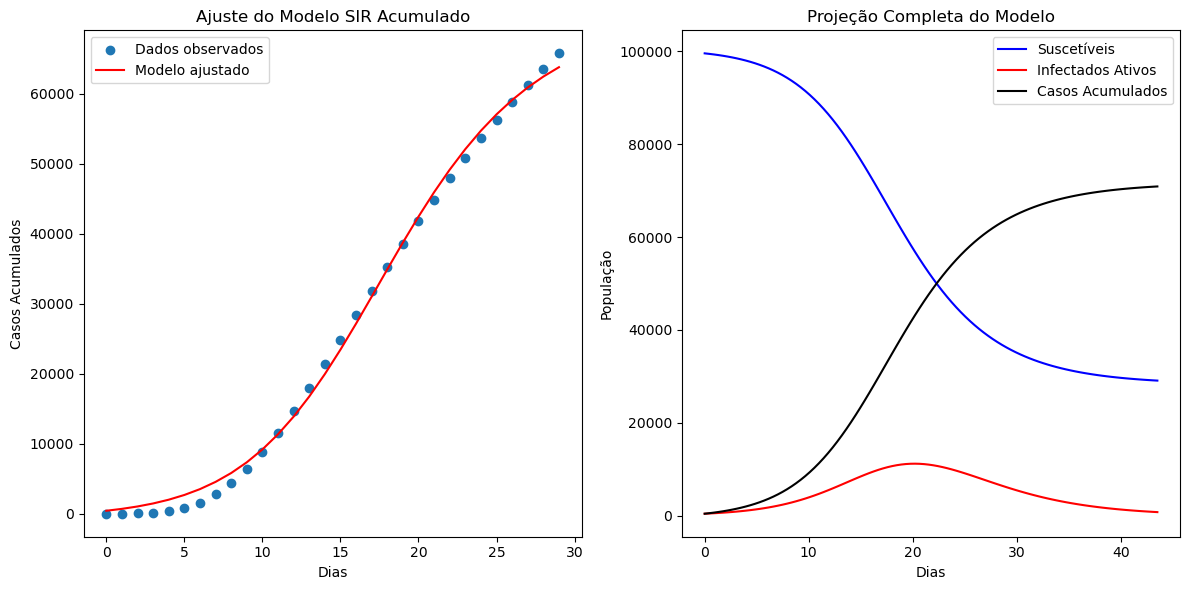

In [15]:
t_data = np.arange(0, 30)
C_data = np.array([10, 30, 80, 180, 380, 780, 1580, 2780, 4380, 6380, 
                      8780, 11580, 14680, 17980, 21380, 24830, 28310, 31790, 
                      35190, 38510, 41740, 44870, 47890, 50800, 53590, 56260, 58810, 61240, 63550, 65740])
N = 100000  # População total
    
# Executar ajuste
result = FIT_SIRC(t_data, C_data, N)
    
#Resultados
print("\n=== Relatório de Ajuste ===")
print(result.fit_report())
    
print("\n=== Estimativas Chave ===")
print(f"Beta (taxa de infecção): {result.params['beta'].value:.4f}")
print(f"Gamma (taxa de recuperação): {result.params['gamma'].value:.4f}")
print(f"R0: {result.params['beta'].value/result.params['gamma'].value:.2f}")
print(f"Total estimado de casos: {result.total_cases:.0f} ({result.total_cases/N:.1%} da população)")
    
    # Visualização
plt.figure(figsize=(12, 6))

# Dados observados vs ajustados
plt.subplot(1, 2, 1)
plt.scatter(t_data, C_data, label='Dados observados')
plt.plot(t_data, result.best_fit, 'r-', label='Modelo ajustado')
plt.xlabel('Dias')
plt.ylabel('Casos Acumulados')
plt.title('Ajuste do Modelo SIR Acumulado')
plt.legend()

# Projeção completa
plt.subplot(1, 2, 2)
plt.plot(result.t_simulation, result.solution[:, 0], 'b-', label='Suscetíveis')
plt.plot(result.t_simulation, result.solution[:, 1], 'r-', label='Infectados Ativos')
plt.plot(result.t_simulation, result.solution[:, 3], 'k-', label='Casos Acumulados')
plt.xlabel('Dias')
plt.ylabel('População')
plt.title('Projeção Completa do Modelo')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# leitura dados
df0= pd.read_parquet("/home/akel/PycharmProjects/Endemic_model/brainstorms/caso_full.parquet")
df0['date']=pd.to_datetime(df0['date'],format='%Y-%m-%d')

dfE=df0.groupby(['date', 'state'])['new_confirmed'].sum().reset_index() #agrupar por estados
dfPA= dfE[dfE['state']=='SP' ]                                          #filtrar estado
dfbel= df0[(df0["city"] == "Belém") & (df0['state']=='PA') ]            #filtrar cidade
print('arquivos lidos')


NCP=dfPA['new_confirmed'].values
NCB=dfbel['new_confirmed'].values

#casos acumulados
CP=np.cumsum(NCP)
Cb=np.cumsum(NCB)

t_date=dfPA['date'].values

# periodo -01/02/2020 - 12/07/2020 (318)
yc=NCP[0:150]
y=CP[0:150]
x=t_date[0:150] 

arquivos lidos



=== Relatório de Ajuste ===
[[Model]]
    Model(solve_SIRC)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 109
    # data points      = 150
    # variables        = 3
    chi-square         = 3.9882e+11
    reduced chi-square = 2.7131e+09
    Akaike info crit   = 3261.17096
    Bayesian info crit = 3270.20287
    R-squared          = 0.96278849
[[Variables]]
    N:      700001 (fixed)
    beta:   0.08180462 +/- 0.02025065 (24.75%) (init = 0.43)
    gamma:  0.00100000 +/- 0.01159401 (1159.40%) (init = 0.29)
    I0:     129.285175 +/- 110.117104 (85.17%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = -0.9828
    C(beta, I0)    = -0.9538
    C(gamma, I0)   = +0.8833

=== Estimativas Chave ===
Beta (taxa de infecção): 0.0818
Gamma (taxa de recuperação): 0.0010
R0: 81.80
Total estimado de casos: 699916 (100.0% da população)


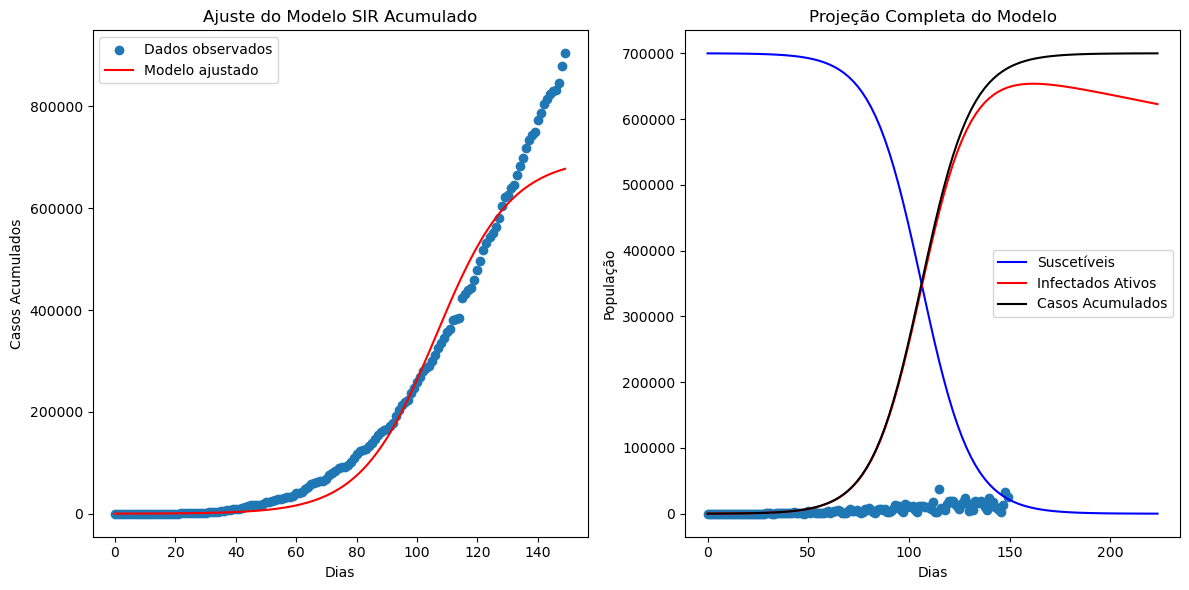

In [18]:
 
t = np.arange(len(y))
N=700001
result = FIT_SIRC(t, y, N)
    
#Resultados
print("\n=== Relatório de Ajuste ===")
print(result.fit_report())
    
print("\n=== Estimativas Chave ===")
print(f"Beta (taxa de infecção): {result.params['beta'].value:.4f}")
print(f"Gamma (taxa de recuperação): {result.params['gamma'].value:.4f}")
print(f"R0: {result.params['beta'].value/result.params['gamma'].value:.2f}")
print(f"Total estimado de casos: {result.total_cases:.0f} ({result.total_cases/N:.1%} da população)")
    
    # Visualização
plt.figure(figsize=(12, 6))

# Dados observados vs ajustados
plt.subplot(1, 2, 1)
plt.scatter(t, y, label='Dados observados')
plt.plot(t, result.best_fit, 'r-', label='Modelo ajustado')
plt.xlabel('Dias')
plt.ylabel('Casos Acumulados')
plt.title('Ajuste do Modelo SIR Acumulado')
plt.legend()



# Projeção completa
plt.subplot(1, 2, 2)
plt.plot(result.t_simulation, result.solution[:, 0], 'b-', label='Suscetíveis')
plt.plot(result.t_simulation, result.solution[:, 1], 'r-', label='Infectados Ativos')
plt.scatter(t,yc)
plt.plot(result.t_simulation, result.solution[:, 3], 'k-', label='Casos Acumulados')
plt.xlabel('Dias')
plt.ylabel('População')
plt.title('Projeção Completa do Modelo')
plt.legend()

plt.tight_layout()
plt.show()

